In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load dataset using ImageFolder
train_dataset = datasets.ImageFolder(root='/content/AIDER-classification-3/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='/content/AIDER-classification-3/valid', transform=transform)
test_dataset  = datasets.ImageFolder(root='/content/AIDER-classification-3/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the class indices
print(train_dataset.class_to_idx)  # {'normal': 0, 'abnormal': 1}


{'abnormal': 0, 'normal': 1}


In [4]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)

        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If the dimensions don't match, we use a 1x1 convolution to match both channels and spatial dimensions
        self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.skip_connection(x)  # Adjust identity dimensions if needed

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Add the skip connection (residual connection)
        out = self.relu(out)

        return out


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder with Residual Blocks
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32, kernel_size=7, stride=2, padding=3),  # Output: (32, 64, 64)
            ResidualBlock(32, 64, kernel_size=7, stride=2, padding=3), # Output: (64, 32, 32)
            ResidualBlock(64, 128, kernel_size=7, stride=2, padding=3), # Output: (128, 16, 16)
            ResidualBlock(128, 256, kernel_size=7, stride=2, padding=3), # Output: (256, 8, 8)
        )

        # Decoder with Residual Blocks
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=7, stride=2, padding=3, output_padding=1),  # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=7, stride=2, padding=3, output_padding=1),  # Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2, padding=3, output_padding=1),  # Output: (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, kernel_size=7, stride=2, padding=3, output_padding=1),  # Output: (3, 128, 128)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2)
      (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_connection): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2)
      (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_connection): Conv2d(32, 64, kernel_

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=150, patience=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    best_valid_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for images, _ in train_bar:  # We ignore labels
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)  # Reconstruction loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Validation Loss Calculation
        model.eval()
        valid_loss = 0

        valid_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
        with torch.no_grad():
            for images, _ in valid_bar:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                valid_loss += loss.item()
                valid_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

        # Early Stopping Check
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            patience_counter = 0  # Reset counter if validation loss improves
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300)

Epoch 1/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.67it/s, loss=0.3137]


Epoch [1/300], Train Loss: 0.2344, Valid Loss: 0.1979


Epoch 2/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.00it/s, loss=0.3032]


Epoch [2/300], Train Loss: 0.1937, Valid Loss: 0.1908


Epoch 3/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.55it/s, loss=0.3013]


Epoch [3/300], Train Loss: 0.1882, Valid Loss: 0.1893


Epoch 4/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.63it/s, loss=0.2972]


Epoch [4/300], Train Loss: 0.1870, Valid Loss: 0.1875


Epoch 5/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.47it/s, loss=0.2953]


Epoch [5/300], Train Loss: 0.1859, Valid Loss: 0.1861


Epoch 6/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.64it/s, loss=0.2957]


Epoch [6/300], Train Loss: 0.1848, Valid Loss: 0.1861


Epoch 7/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s, loss=0.2937]


Epoch [7/300], Train Loss: 0.1840, Valid Loss: 0.1849


Epoch 8/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.88it/s, loss=0.2951]


Epoch [8/300], Train Loss: 0.1839, Valid Loss: 0.1848


Epoch 9/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.71it/s, loss=0.2934]


Epoch [9/300], Train Loss: 0.1833, Valid Loss: 0.1845


Epoch 10/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.69it/s, loss=0.2931]


Epoch [10/300], Train Loss: 0.1831, Valid Loss: 0.1842


Epoch 11/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.79it/s, loss=0.2923]


Epoch [11/300], Train Loss: 0.1818, Valid Loss: 0.1837


Epoch 12/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.38it/s, loss=0.2921]


Epoch [12/300], Train Loss: 0.1819, Valid Loss: 0.1841


Epoch 13/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s, loss=0.2924]


Epoch [13/300], Train Loss: 0.1817, Valid Loss: 0.1837


Epoch 14/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.51it/s, loss=0.2918]


Epoch [14/300], Train Loss: 0.1813, Valid Loss: 0.1832


Epoch 15/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s, loss=0.2908]


Epoch [15/300], Train Loss: 0.1811, Valid Loss: 0.1826


Epoch 16/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s, loss=0.2902]


Epoch [16/300], Train Loss: 0.1806, Valid Loss: 0.1823


Epoch 17/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.80it/s, loss=0.2902]


Epoch [17/300], Train Loss: 0.1804, Valid Loss: 0.1822


Epoch 18/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.44it/s, loss=0.2900]


Epoch [18/300], Train Loss: 0.1800, Valid Loss: 0.1822


Epoch 19/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.80it/s, loss=0.2898]


Epoch [19/300], Train Loss: 0.1799, Valid Loss: 0.1820


Epoch 20/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.71it/s, loss=0.2897]


Epoch [20/300], Train Loss: 0.1797, Valid Loss: 0.1818


Epoch 21/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.79it/s, loss=0.2891]


Epoch [21/300], Train Loss: 0.1795, Valid Loss: 0.1815


Epoch 22/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s, loss=0.2901]


Epoch [22/300], Train Loss: 0.1794, Valid Loss: 0.1820


Epoch 23/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s, loss=0.2887]


Epoch [23/300], Train Loss: 0.1794, Valid Loss: 0.1811


Epoch 24/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.66it/s, loss=0.2886]


Epoch [24/300], Train Loss: 0.1787, Valid Loss: 0.1811


Epoch 25/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.40it/s, loss=0.2885]


Epoch [25/300], Train Loss: 0.1792, Valid Loss: 0.1810


Epoch 26/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.61it/s, loss=0.2885]


Epoch [26/300], Train Loss: 0.1785, Valid Loss: 0.1810


Epoch 27/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.73it/s, loss=0.2884]


Epoch [27/300], Train Loss: 0.1787, Valid Loss: 0.1809


Epoch 28/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.79it/s, loss=0.2884]


Epoch [28/300], Train Loss: 0.1784, Valid Loss: 0.1808


Epoch 29/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s, loss=0.2896]


Epoch [29/300], Train Loss: 0.1785, Valid Loss: 0.1812


Epoch 30/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.21it/s, loss=0.2881]


Epoch [30/300], Train Loss: 0.1784, Valid Loss: 0.1808


Epoch 31/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.75it/s, loss=0.2888]


Epoch [31/300], Train Loss: 0.1786, Valid Loss: 0.1808


Epoch 32/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.61it/s, loss=0.2892]


Epoch [32/300], Train Loss: 0.1782, Valid Loss: 0.1814


Epoch 33/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.73it/s, loss=0.2882]


Epoch [33/300], Train Loss: 0.1782, Valid Loss: 0.1804


Epoch 34/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.69it/s, loss=0.2883]


Epoch [34/300], Train Loss: 0.1782, Valid Loss: 0.1807


Epoch 35/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s, loss=0.2884]


Epoch [35/300], Train Loss: 0.1781, Valid Loss: 0.1806


Epoch 36/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s, loss=0.2879]


Epoch [36/300], Train Loss: 0.1780, Valid Loss: 0.1803


Epoch 37/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.66it/s, loss=0.2876]


Epoch [37/300], Train Loss: 0.1778, Valid Loss: 0.1803


Epoch 38/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.82it/s, loss=0.2885]


Epoch [38/300], Train Loss: 0.1778, Valid Loss: 0.1807


Epoch 39/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.87it/s, loss=0.2881]


Epoch [39/300], Train Loss: 0.1777, Valid Loss: 0.1803


Epoch 40/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.68it/s, loss=0.2882]


Epoch [40/300], Train Loss: 0.1777, Valid Loss: 0.1807


Epoch 41/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s, loss=0.2877]


Epoch [41/300], Train Loss: 0.1777, Valid Loss: 0.1801


Epoch 42/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.35it/s, loss=0.2876]


Epoch [42/300], Train Loss: 0.1776, Valid Loss: 0.1801


Epoch 43/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.53it/s, loss=0.2876]


Epoch [43/300], Train Loss: 0.1777, Valid Loss: 0.1801


Epoch 44/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.78it/s, loss=0.2877]


Epoch [44/300], Train Loss: 0.1775, Valid Loss: 0.1803


Epoch 45/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.87it/s, loss=0.2882]


Epoch [45/300], Train Loss: 0.1775, Valid Loss: 0.1803


Epoch 46/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.99it/s, loss=0.2873]


Epoch [46/300], Train Loss: 0.1774, Valid Loss: 0.1799


Epoch 47/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s, loss=0.2878]


Epoch [47/300], Train Loss: 0.1778, Valid Loss: 0.1801


Epoch 48/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.00it/s, loss=0.2874]


Epoch [48/300], Train Loss: 0.1775, Valid Loss: 0.1799


Epoch 49/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.45it/s, loss=0.2877]


Epoch [49/300], Train Loss: 0.1777, Valid Loss: 0.1803


Epoch 50/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.58it/s, loss=0.2878]


Epoch [50/300], Train Loss: 0.1778, Valid Loss: 0.1800


Epoch 51/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.69it/s, loss=0.2879]


Epoch [51/300], Train Loss: 0.1774, Valid Loss: 0.1803


Epoch 52/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.58it/s, loss=0.2876]


Epoch [52/300], Train Loss: 0.1776, Valid Loss: 0.1800


Epoch 53/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.60it/s, loss=0.2901]


Epoch [53/300], Train Loss: 0.1777, Valid Loss: 0.1810


Epoch 54/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s, loss=0.2872]


Epoch [54/300], Train Loss: 0.1772, Valid Loss: 0.1797


Epoch 55/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.49it/s, loss=0.2876]


Epoch [55/300], Train Loss: 0.1774, Valid Loss: 0.1799


Epoch 56/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.59it/s, loss=0.2871]


Epoch [56/300], Train Loss: 0.1772, Valid Loss: 0.1796


Epoch 57/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.60it/s, loss=0.2870]


Epoch [57/300], Train Loss: 0.1771, Valid Loss: 0.1796


Epoch 58/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.59it/s, loss=0.2869]


Epoch [58/300], Train Loss: 0.1771, Valid Loss: 0.1797


Epoch 59/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.43it/s, loss=0.2869]


Epoch [59/300], Train Loss: 0.1770, Valid Loss: 0.1796


Epoch 60/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.74it/s, loss=0.2885]


Epoch [60/300], Train Loss: 0.1775, Valid Loss: 0.1803


Epoch 61/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.11it/s, loss=0.2869]


Epoch [61/300], Train Loss: 0.1772, Valid Loss: 0.1796


Epoch 62/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.67it/s, loss=0.2870]


Epoch [62/300], Train Loss: 0.1770, Valid Loss: 0.1796


Epoch 63/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.63it/s, loss=0.2869]


Epoch [63/300], Train Loss: 0.1769, Valid Loss: 0.1795


Epoch 64/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.63it/s, loss=0.2869]


Epoch [64/300], Train Loss: 0.1772, Valid Loss: 0.1796


Epoch 65/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.23it/s, loss=0.2873]


Epoch [65/300], Train Loss: 0.1769, Valid Loss: 0.1796


Epoch 66/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s, loss=0.2879]


Epoch [66/300], Train Loss: 0.1768, Valid Loss: 0.1799


Epoch 67/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s, loss=0.2870]


Epoch [67/300], Train Loss: 0.1767, Valid Loss: 0.1797


Epoch 68/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.65it/s, loss=0.2872]


Epoch [68/300], Train Loss: 0.1773, Valid Loss: 0.1795


Epoch 69/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.84it/s, loss=0.2867]


Epoch [69/300], Train Loss: 0.1771, Valid Loss: 0.1794


Epoch 70/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.65it/s, loss=0.2875]


Epoch [70/300], Train Loss: 0.1768, Valid Loss: 0.1798


Epoch 71/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.86it/s, loss=0.2871]


Epoch [71/300], Train Loss: 0.1768, Valid Loss: 0.1795


Epoch 72/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s, loss=0.2871]


Epoch [72/300], Train Loss: 0.1769, Valid Loss: 0.1795


Epoch 73/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s, loss=0.2866]


Epoch [73/300], Train Loss: 0.1767, Valid Loss: 0.1792


Epoch 74/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.58it/s, loss=0.2867]


Epoch [74/300], Train Loss: 0.1765, Valid Loss: 0.1793


Epoch 75/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.63it/s, loss=0.2864]


Epoch [75/300], Train Loss: 0.1765, Valid Loss: 0.1792


Epoch 76/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.49it/s, loss=0.2865]


Epoch [76/300], Train Loss: 0.1764, Valid Loss: 0.1792


Epoch 77/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.55it/s, loss=0.2864]


Epoch [77/300], Train Loss: 0.1766, Valid Loss: 0.1791


Epoch 78/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s, loss=0.2867]


Epoch [78/300], Train Loss: 0.1767, Valid Loss: 0.1793


Epoch 79/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s, loss=0.2865]


Epoch [79/300], Train Loss: 0.1764, Valid Loss: 0.1792


Epoch 80/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.06it/s, loss=0.2867]


Epoch [80/300], Train Loss: 0.1766, Valid Loss: 0.1793


Epoch 81/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.73it/s, loss=0.2864]


Epoch [81/300], Train Loss: 0.1767, Valid Loss: 0.1791


Epoch 82/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.70it/s, loss=0.2878]


Epoch [82/300], Train Loss: 0.1766, Valid Loss: 0.1797


Epoch 83/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.66it/s, loss=0.2863]


Epoch [83/300], Train Loss: 0.1765, Valid Loss: 0.1791


Epoch 84/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.29it/s, loss=0.2863]


Epoch [84/300], Train Loss: 0.1762, Valid Loss: 0.1791


Epoch 85/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s, loss=0.2862]


Epoch [85/300], Train Loss: 0.1764, Valid Loss: 0.1790


Epoch 86/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.12it/s, loss=0.2862]


Epoch [86/300], Train Loss: 0.1764, Valid Loss: 0.1790


Epoch 87/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.53it/s, loss=0.2882]


Epoch [87/300], Train Loss: 0.1764, Valid Loss: 0.1800


Epoch 88/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.86it/s, loss=0.2865]


Epoch [88/300], Train Loss: 0.1765, Valid Loss: 0.1791


Epoch 89/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.55it/s, loss=0.2864]


Epoch [89/300], Train Loss: 0.1764, Valid Loss: 0.1791


Epoch 90/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.56it/s, loss=0.2863]


Epoch [90/300], Train Loss: 0.1765, Valid Loss: 0.1790


Epoch 91/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s, loss=0.2864]


Epoch [91/300], Train Loss: 0.1763, Valid Loss: 0.1792


Epoch 92/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s, loss=0.2863]


Epoch [92/300], Train Loss: 0.1764, Valid Loss: 0.1790


Epoch 93/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.51it/s, loss=0.2863]


Epoch [93/300], Train Loss: 0.1762, Valid Loss: 0.1789


Epoch 94/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.70it/s, loss=0.2873]


Epoch [94/300], Train Loss: 0.1763, Valid Loss: 0.1794


Epoch 95/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.60it/s, loss=0.2862]


Epoch [95/300], Train Loss: 0.1761, Valid Loss: 0.1789


Epoch 96/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.65it/s, loss=0.2868]


Epoch [96/300], Train Loss: 0.1763, Valid Loss: 0.1792


Epoch 97/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  5.02it/s, loss=0.2860]


Epoch [97/300], Train Loss: 0.1761, Valid Loss: 0.1788


Epoch 98/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.62it/s, loss=0.2861]


Epoch [98/300], Train Loss: 0.1762, Valid Loss: 0.1790


Epoch 99/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s, loss=0.2861]


Epoch [99/300], Train Loss: 0.1761, Valid Loss: 0.1788


Epoch 100/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.60it/s, loss=0.2864]


Epoch [100/300], Train Loss: 0.1760, Valid Loss: 0.1792


Epoch 101/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.77it/s, loss=0.2862]


Epoch [101/300], Train Loss: 0.1761, Valid Loss: 0.1788


Epoch 102/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.47it/s, loss=0.2863]


Epoch [102/300], Train Loss: 0.1762, Valid Loss: 0.1789


Epoch 103/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.27it/s, loss=0.2863]


Epoch [103/300], Train Loss: 0.1760, Valid Loss: 0.1790


Epoch 104/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.77it/s, loss=0.2862]


Epoch [104/300], Train Loss: 0.1758, Valid Loss: 0.1788


Epoch 105/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s, loss=0.2861]


Epoch [105/300], Train Loss: 0.1760, Valid Loss: 0.1788


Epoch 106/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.51it/s, loss=0.2860]


Epoch [106/300], Train Loss: 0.1761, Valid Loss: 0.1788


Epoch 107/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.66it/s, loss=0.2861]


Epoch [107/300], Train Loss: 0.1760, Valid Loss: 0.1788


Epoch 108/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.60it/s, loss=0.2861]


Epoch [108/300], Train Loss: 0.1760, Valid Loss: 0.1787


Epoch 109/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.49it/s, loss=0.2862]


Epoch [109/300], Train Loss: 0.1759, Valid Loss: 0.1788


Epoch 110/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.70it/s, loss=0.2861]


Epoch [110/300], Train Loss: 0.1760, Valid Loss: 0.1788


Epoch 111/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s, loss=0.2860]


Epoch [111/300], Train Loss: 0.1760, Valid Loss: 0.1787


Epoch 112/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.59it/s, loss=0.2860]


Epoch [112/300], Train Loss: 0.1758, Valid Loss: 0.1787


Epoch 113/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.55it/s, loss=0.2860]


Epoch [113/300], Train Loss: 0.1760, Valid Loss: 0.1788


Epoch 114/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.50it/s, loss=0.2860]


Epoch [114/300], Train Loss: 0.1760, Valid Loss: 0.1788


Epoch 115/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.62it/s, loss=0.2861]


Epoch [115/300], Train Loss: 0.1759, Valid Loss: 0.1788


Epoch 116/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s, loss=0.2865]


Epoch [116/300], Train Loss: 0.1758, Valid Loss: 0.1790


Epoch 117/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s, loss=0.2860]


Epoch [117/300], Train Loss: 0.1759, Valid Loss: 0.1787


Epoch 118/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s, loss=0.2861]


Epoch [118/300], Train Loss: 0.1758, Valid Loss: 0.1787


Epoch 119/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.49it/s, loss=0.2862]


Epoch [119/300], Train Loss: 0.1756, Valid Loss: 0.1787


Epoch 120/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.53it/s, loss=0.2858]


Epoch [120/300], Train Loss: 0.1760, Valid Loss: 0.1786


Epoch 121/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.66it/s, loss=0.2863]


Epoch [121/300], Train Loss: 0.1758, Valid Loss: 0.1788


Epoch 122/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.70it/s, loss=0.2859]


Epoch [122/300], Train Loss: 0.1757, Valid Loss: 0.1786


Epoch 123/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.67it/s, loss=0.2876]


Epoch [123/300], Train Loss: 0.1760, Valid Loss: 0.1793


Epoch 124/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s, loss=0.2859]


Epoch [124/300], Train Loss: 0.1757, Valid Loss: 0.1786


Epoch 125/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s, loss=0.2862]


Epoch [125/300], Train Loss: 0.1756, Valid Loss: 0.1790


Epoch 126/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.57it/s, loss=0.2858]


Epoch [126/300], Train Loss: 0.1758, Valid Loss: 0.1786


Epoch 127/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.77it/s, loss=0.2861]


Epoch [127/300], Train Loss: 0.1755, Valid Loss: 0.1787


Epoch 128/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.71it/s, loss=0.2860]


Epoch [128/300], Train Loss: 0.1758, Valid Loss: 0.1787


Epoch 129/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.62it/s, loss=0.2862]


Epoch [129/300], Train Loss: 0.1757, Valid Loss: 0.1790


Epoch 130/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s, loss=0.2864]


Epoch [130/300], Train Loss: 0.1759, Valid Loss: 0.1788


Epoch 131/300 [Validation]: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s, loss=0.2858]


Epoch [131/300], Train Loss: 0.1756, Valid Loss: 0.1786


Epoch 132/300 [Validation]: 100%|██████████| 21/21 [00:03<00:00,  5.49it/s, loss=0.2859]

Epoch [132/300], Train Loss: 0.1757, Valid Loss: 0.1787
Early stopping triggered.


In [7]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.encoder = model.encoder  # Use pretrained encoder
        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output: 2 classes (Normal, Abnormal)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Instantiate and Train Classifier
classifier = BinaryClassifier()
classifier.to("cuda" if torch.cuda.is_available() else "cpu")


BinaryClassifier(
  (encoder): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2)
      (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_connection): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2)
      (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_connection): Conv2d(32, 64, kernel

Test Accuracy: 62.05%


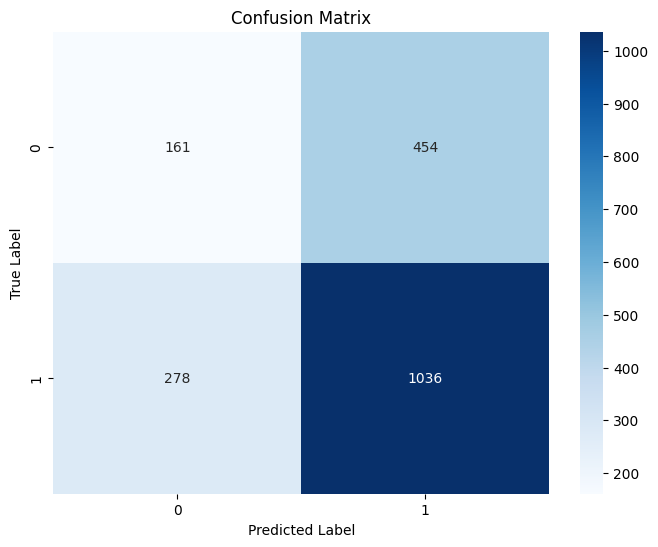

In [8]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(classifier, test_loader)


In [9]:
torch.save(model.state_dict(), "autoencoder.pth")
torch.save(classifier.state_dict(), "classifier.pth")